In [185]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

INF = 99.0
X, O, BLANK = 'X', 'O', ' '
N = 8
DOWN, UP = 1, -1

class State():
    
    def __init__(self, state=None, N=N):
        self.board = X*N + BLANK*(N-2)*N + O*N
        self.turn = X
        
        if state is not None:
            if type(state) is str:
                self.board = state
            else:
                self.board = state.board
                self.turn = state.turn 
            
    def move(self, move):
        ''' Moves players piece from Start to End index '''
        s, e = move
        player = self.board[s]
        # Remove piece
        self.board = self.board[:s] + BLANK + self.board[s+1:]
        # Place piece
        self.board = self.board[:e] + player + self.board[e+1:] 
        self.turn = X if self.turn == O else O
    
    def terminal_test(self):
        ''' Returns the victorious player if there is one '''
        # All pieces taken
        if X not in self.board:
            return -INF
        if O not in self.board:
            return INF
        
        # Check if either player has crossed board
        if X in self.board[N*(N-1):]:
            return INF
        if O in self.board[:N]:
            return -INF
        
        # Check if player cannot move, (return opponent as winner if so)
        if len(self.actions()) == 0:
            return INF if self.turn == O else -INF
        
        return None
            
    def __str__(self):        
        return (2*N+1)*'_' + ''.join(['\n|' + ''.join([e + '|' for e in self.board[i:i+N]]) + ' ' + \
                                     ''.join([str(j).rjust(3) for j in range(i, i+N)]) for i in range(0, N**2, N)])    
    
    def __repr__(self):
        return str(self)
    
    def actions(self):
        ''' Returns a list of possible actions for the player '''
        player   = X if self.turn == X else O
        opponent = O if self.turn == X else X
        direction = DOWN if player == X else UP
    
        # Find pieces
        lst = [i for i in range(N**2) if self.board[i] == player]

        actions = []
        for i in lst:
            # Check vertical is valid and free
            if (0 <= i+N*direction < N**2) and (self.board[i+N*direction] == BLANK):
                actions.append((i, i+N*direction))

            # Check diagonals are valid and taken by opposition
            # If not on left, check left
            new_i = i + N*direction - 1
            if (i%N != 0) and (0 <= new_i) and (self.board[new_i] == opponent):
                actions.append((i, new_i))

            # If not on right, check right
            new_i = i + N*direction + 1
            if ((i+1)%N != 0) and (new_i < N**2) and (self.board[new_i] == opponent):
                actions.append((i, new_i))

        return actions
    
    def flip(self):
        board = ''
        for space in self.board:
            if space == X:
                board += O
            elif space == O:
                board += X
            else:
                board += BLANK
        self.board = board[::-1]
        self.turn = X if self.turn == O else X

In [325]:
def even_sum(board, player):
        ''' Return 1 if there is an even number of spaces between each player in each column '''
        total = 1 if player == X else 0
        for column in range(8):
            col = [board[i] for i in range(column, N**2, N)]
            if X in col and O in col:
                Oi = col.index(O)
                Xi = N - col[::-1].index(X)
                total += Oi + Xi
        return 2*((total)% 2 - 0.5)

even_sum('        ' +
         '        ' +
         '        ' +
         '        ' +
         '     X  ' +
         '  X     ' +
         ' X  X   ' +
         ' OO  O  ', O)

1.0

In [353]:
def Φ(state):
    b = state.board

    def pieces(board, player):
        return (board.count(player) - 4)/4
    
    def row(board, r, player):
        add = 2*N
        if player == O:
            add = 1*N
        return (board[N*r+add:N*(r+1)+add].count(player) - 4)/4
    
    def n_actions(b, player):
        s = State(b)
        s.turn = player
        return (len(s.actions()) - 7)/7
    
    def n_end_in_sight(board, player):
        ''' Doesnt account for situation XOX '''
        direction = DOWN if player == X else UP
        opponent = O if player == X else X
        
        count = 0
        for column in range(8):
            col = [board[i] for i in range(column, N**2, N)][::direction]
            if player in col:
                if opponent not in col:
                    count += 1
                elif col.index(player) < col.index(opponent):
                    count += 1
        return count
    
    def n_freedom(board, player):
        ''' Returns 1 if the player in the column can reach the end without danger'''
        direction = DOWN if player == X else UP
        opponent = O if player == X else X
        
        free = 0
        for column in range(N):
            col = [board[i] for i in range(column, N**2, N)][::-direction]
            if player not in col:
                continue

            centre = col[::-1][N-col.index(player):]
            if opponent in centre:
                continue

            if column != 0:
                left = [board[i-1] for i in range(column, N**2, N)][::-direction]
                left = left[::-1][N-col.index(player):]
                if opponent in left:
                    continue

            if column != N-1:
                right = [board[i+1] for i in range(column, N**2, N)][::-direction]
                right = right[::-1][N-col.index(player):]
                if opponent in right:
                    continue

            free += 1
        if free:
            return free
        return -1

    def av_furthest_piece(board, player):
        direction = DOWN if player == X else UP
        
        count = furthest = 0
        for column in range(8):
            col = [board[i] for i in range(column, N**2, N)][::-direction]
            if player in col:
                furthest += (N - col.index(player))**2
                count += 36
        return 2*(furthest/count - 0.5)
    
    def n_doubled_up(board, player):
        count = 0
        for column in range(8):
            col = [board[i] for i in range(column, N**2, N)]
            if col.count(player) > 1:
                count += 1
        return count

    def n_connected(board, player):
        direction = DOWN if player == X else UP

         # Find pieces
        pieces = [i for i in range(N**2) if board[i] == player]

        count = 0
        for i in pieces:
            # Check diagonals are valid and taken by opposition
            # If not on left, check left
            new_i = i + N*direction - 1
            if (i%N != 0) and (0 <= new_i) and (board[new_i] == player):
                count += 1

            # If not on right, check right
            new_i = i + N*direction + 1
            if ((i+1)%N != 0) and (new_i < N**2) and (board[new_i] == player):
                count += 1
        return count
        
    return np.array([n_actions(b, player) for player in [X, O]] +
                    [pieces(b, player) for player in [X, O]] +
                    [row(b, r, player) for player in [X, O] for r in range(N-3)] +
                    [n_end_in_sight(b, player) for player in [X, O]] +
                    [av_furthest_piece(b, player) for player in [X, O]] +
                    [n_freedom(b, player) for player in [X, O]] +
                    [n_doubled_up(b, player) for player in [X, O]] +
                    [n_connected(b, player) for player in [X, O]])

def H(s, θ):
    h = np.dot(Φ(s), θ)
    if h < -INF:
        return -INF*0.99
    if h > +INF:
        return +INF*0.99
    return h

α = 0.000001
MAX_CHANGE = 0.1
def tree_strap_train(θ, depth=2, printing=False):
    state = State()
    turn = 0
    random_turns = np.random.choice([0] + [2]*2 + [4]*4 + [8]*8 + 16*[16] + 32*[32])
    
    print(state) if printing else None
    
    while state.terminal_test() is None:
        if turn < random_turns:
            state.move(state.actions()[np.random.choice([i for i in range(len(state.actions()))])])
        else:
            searched_states = []
            V = minimax(state, depth, True, θ, searched_states)
            h = H(state, θ)

            𝛿 = V - h
            Δθ = α*𝛿*Φ(state)
            flip = State(state)
            flip.flip()
            𝛿 = -(V - h)
            Δθ += α*𝛿*Φ(state)
            for s, vs, hs in searched_states:
                #𝛿 = V(s) - H(s, θ)
                𝛿 = vs - hs
                Δθ += α*𝛿*Φ(s)
                s.flip()
                𝛿 = -(vs - hs)
                Δθ += α*𝛿*Φ(s)
            for i in range(len(Δθ)):
                if Δθ[i] > MAX_CHANGE:
                    Δθ[i] = MAX_CHANGE
                elif Δθ[i] < -MAX_CHANGE:
                    Δθ[i] = -MAX_CHANGE
            θ += Δθ

            actions = []
            for action in state.actions():
                result = State(state)
                result.move(action)
                actions.append((minimax(result, depth-1, False, θ), action))
                
            state.move(max(actions)[1])
                
        print(state) if printing else None 
        turn += 1
        state.flip()
    return θ

def minimax(state, depth, isMax, θ, searched_states=None):
    if state.terminal_test() is not None:
        return state.terminal_test()
    if depth == 0:
        return H(state, θ)
    
    if isMax:
        maxEval = -INF
        for a in state.actions():
            result = State(state)
            result.move(a)
            maxEval = max(maxEval, minimax(result, depth-1, not isMax, θ, searched_states))
        
        if searched_states is not None:
            # Store the state, it's V(s) and H(s)
            searched_states.append((state, maxEval, H(state, θ)))
        return maxEval
    
    else:
        minEval = +INF
        for a in state.actions():
            result = State(state)
            result.move(a)
            minEval = min(minEval, minimax(result, depth-1, not isMax, θ, searched_states))
            
        if searched_states is not None:
            # Store the state, it's V(s) and H(s)
            searched_states.append((state, minEval, H(state, θ)))
        return minEval

In [357]:
θ = np.array([   5116.03480422,  -5116.03480422,   6623.64446503,  -6623.64446503,
                -1177.8542315 ,  -2171.02605057,  -2014.93398157,   -248.55525542,
                19546.47972397, -19546.47972397,    689.31025542,   2527.00076157,
                 2171.02605057,   1177.8542315 ,   3633.964     ,  -3633.964     ,
                 4799.88096148,  -4799.88096148,  15235.61900002, -15235.61900002,
                 4643.51327644,  -4643.51327644,   -151.45064808,    151.45064808])

#θ = np.array([np.random.uniform(-0.1, 0.1) for _ in range(54)]) 
θs = [np.copy(θ)]
len(θ), len(Φ(State()))

(24, 24)

In [352]:
θ

array([ 0.97001339, -0.97001339,  1.50837682, -1.50837682,  0.13824242,
       -0.03223433,  0.00869185,  0.19126227,  2.62744886, -2.62744886,
       -0.14718677,  0.04251483,  0.03223433, -0.13824242,  1.7826108 ,
       -1.7826108 ,  1.82254048, -1.82254048,  4.75391774, -4.75391774,
        2.4291864 , -2.4291864 ,  5.94749433, -5.94749433])

In [354]:
i = 0
while True:
    if i%1000 == 0:
        print(i, end=' ')
    θ = tree_strap_train(θ, depth=2)
    θs.append(np.copy(θ))
    i += 1

0 1000 2000 3000 4000 

KeyboardInterrupt: 

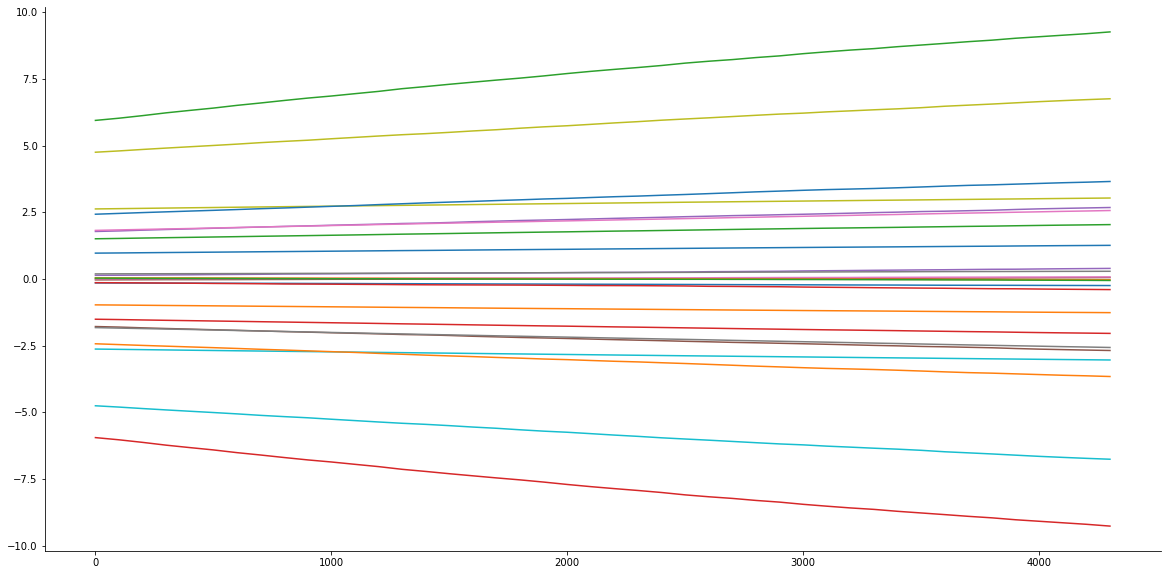

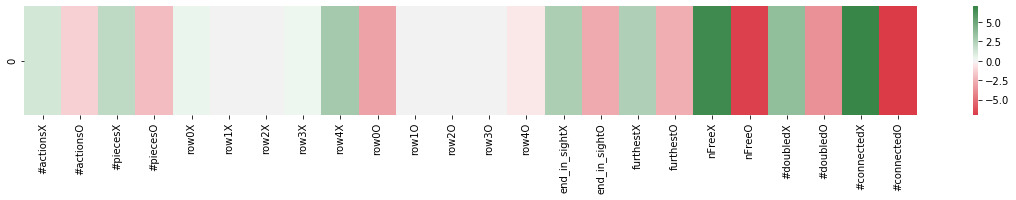

In [356]:
fig, ax = plt.subplots(figsize=(20, 10))
for i in range(len(θ)):
    x = [j for j in range(len(θs))][::100]
    y = [θs[j][i] for j in range(len(θs))][::100]
    ax.plot(x, y)
sns.despine()
plt.show()

FACTOR=7
cmap = sns.diverging_palette(10, 133, as_cmap=True)
lbls = ['#actionsX', '#actionsO', '#piecesX', '#piecesO'] + [f'row{r}{p}' for p in [X, O] for r in range(N-3)] + \
       [f'end_in_sight{p}' for p in [X, O]] + [f'furthest{p}' for p in [X, O]] + \
       ['nFreeX', 'nFreeO', '#doubledX', '#doubledO', '#connectedX', '#connectedO']

fig, ax = plt.subplots(figsize=(20, 2))
sns.heatmap([θ], cmap=cmap, vmin=-FACTOR, vmax=FACTOR, ax=ax, xticklabels=lbls)
plt.show()

In [276]:
TREESTRAP, RANDOM, HUMAN = 0, 1, 2

def ab_pruning(state, depth, α, β, θ, isMax):
    if state.terminal_test() is not None:
        return state.terminal_test()
    if depth == 0:
        return H(state, θ)
    
    if isMax:
        maxV = -INF
        for action in state.actions():
            result = State(state)
            result.move(action)
            value = ab_pruning(result, depth-1, α, β, θ, isMax=False)
            maxV = max(maxV, value)
            α = max(α, value)
            if β <= α:
                break
        return maxV
    else:
        minV = +INF
        for action in state.actions():
            result = State(state)
            result.move(action)
            value = ab_pruning(result, depth-1, α, β, θ, isMax=True)
            minV = min(minV, value)
            β = min(β, value)
            if β <= α:
                break
        return minV

def random_move(state, θ=None, depth=None):
    if depth is not None or θ is not None:
        raise ValueError 
    actions = state.actions()
    return actions[np.random.choice([i for i in range(len(actions))])]

def tree_strap_move(state, θ, depth=5):
    if depth is None:
        raise ValueError 
    
    actions = []
    for action in state.actions():
        result = State(state)
        result.move(action)
        # If terminal state, no need to search
        if result.terminal_test() is not None:
            rn = result.terminal_test()
            actions.append((rn, action))
        else:
            isMax = True if result.turn == X else False
            actions.append((ab_pruning(result, depth, -INF, INF, θ, isMax=isMax), action))
    
    if state.turn == X:
        #print(actions)
        return max(actions)[1]
    return min(actions)[1]

def play(playerX=TREESTRAP, playerO=HUMAN, θX=None, θO=None, depthX=None, depthO=None, printing=False):
    if playerX == HUMAN:
        raise ValueError('You Monster!')
        
    s = State()
    s.turn = np.random.choice([X, O])
    
    def play_human(ai):
        print(s)
        turn = 0
        while s.terminal_test() is None:
            if s.turn == O:
                print('\n', list(enumerate(s.actions())), sep='')
                i = int(input())
                s.move(s.actions()[i])
            else:
                if turn < 30:
                    s.move(MOVE[playerX](s, θX, depthX))
                else:
                    s.move(MOVE[playerX](s, θX, depthX+2))
                    
                
            turn += 1

            print(s)
        print('\nGame Over!')
    
    if playerO == HUMAN:
        play_human(ai=playerX)
    else:
        print(s) if printing else None
        while s.terminal_test() is None:
            if s.turn == X:
                s.move(MOVE[playerX](s, θX, depthX))
            else:
                s.move(MOVE[playerO](s, θO, depthO))
            print(s) if printing else None
            
    θs.append(np.copy(θ))
    return int(s.terminal_test() > 0)

def validate(nGames=1, playerX=TREESTRAP, playerO=RANDOM, θX=θ, θO=None, depthX=2, depthO=None):
    wins = 0
    for _ in range(nGames):
        wins += play(playerX, playerO, θX, θO, depthX, depthO, printing=False)
    p = wins/nGames
    return p, (max(0, p - 1.96*np.sqrt(p*(1-p)/nGames)), min(1, p + 1.96*np.sqrt(p*(1-p)/nGames)))

MOVE = {TREESTRAP: tree_strap_move, RANDOM: random_move}

#validate(nGames=10)

In [361]:
play(playerX=TREESTRAP, playerO=HUMAN, θX=θlargea, θO=None, depthX=4, depthO=None, printing=False)

_________________
|X|X|X|X|X|X|X|X|   0  1  2  3  4  5  6  7
| | | | | | | | |   8  9 10 11 12 13 14 15
| | | | | | | | |  16 17 18 19 20 21 22 23
| | | | | | | | |  24 25 26 27 28 29 30 31
| | | | | | | | |  32 33 34 35 36 37 38 39
| | | | | | | | |  40 41 42 43 44 45 46 47
| | | | | | | | |  48 49 50 51 52 53 54 55
|O|O|O|O|O|O|O|O|  56 57 58 59 60 61 62 63
_________________
|X|X|X|X|X|X|X| |   0  1  2  3  4  5  6  7
| | | | | | | |X|   8  9 10 11 12 13 14 15
| | | | | | | | |  16 17 18 19 20 21 22 23
| | | | | | | | |  24 25 26 27 28 29 30 31
| | | | | | | | |  32 33 34 35 36 37 38 39
| | | | | | | | |  40 41 42 43 44 45 46 47
| | | | | | | | |  48 49 50 51 52 53 54 55
|O|O|O|O|O|O|O|O|  56 57 58 59 60 61 62 63

[(0, (56, 48)), (1, (57, 49)), (2, (58, 50)), (3, (59, 51)), (4, (60, 52)), (5, (61, 53)), (6, (62, 54)), (7, (63, 55))]
4
_________________
|X|X|X|X|X|X|X| |   0  1  2  3  4  5  6  7
| | | | | | | |X|   8  9 10 11 12 13 14 15
| | | | | | | | |  16 17 18 19 20 21 22 23
| | |

1
_________________
|X|X|X|X|X|X| | |   0  1  2  3  4  5  6  7
| | | | | | | | |   8  9 10 11 12 13 14 15
| | |O| |O| | | |  16 17 18 19 20 21 22 23
| | | | | | | | |  24 25 26 27 28 29 30 31
| | | | | | | | |  32 33 34 35 36 37 38 39
| | | | | | |X|X|  40 41 42 43 44 45 46 47
| | | | | | | | |  48 49 50 51 52 53 54 55
|O|O| |O| |O|O|O|  56 57 58 59 60 61 62 63
_________________
|X|X|X|X|X|X| | |   0  1  2  3  4  5  6  7
| | | | | | | | |   8  9 10 11 12 13 14 15
| | |O| |O| | | |  16 17 18 19 20 21 22 23
| | | | | | | | |  24 25 26 27 28 29 30 31
| | | | | | | | |  32 33 34 35 36 37 38 39
| | | | | | |X| |  40 41 42 43 44 45 46 47
| | | | | | | |X|  48 49 50 51 52 53 54 55
|O|O| |O| |O|O|O|  56 57 58 59 60 61 62 63

[(0, (18, 10)), (1, (20, 12)), (2, (56, 48)), (3, (57, 49)), (4, (59, 51)), (5, (61, 53)), (6, (62, 54)), (7, (62, 55))]
7
_________________
|X|X|X|X|X|X| | |   0  1  2  3  4  5  6  7
| | | | | | | | |   8  9 10 11 12 13 14 15
| | |O| |O| | | |  16 17 18 19 20 21 22 23
| |

0
_________________
|X| | | | | | | |   0  1  2  3  4  5  6  7
| |X| | | | | | |   8  9 10 11 12 13 14 15
| | | | | | | | |  16 17 18 19 20 21 22 23
| | | |X| |X| | |  24 25 26 27 28 29 30 31
| | | |O| |O| | |  32 33 34 35 36 37 38 39
|O| | | | | | | |  40 41 42 43 44 45 46 47
| | | | | | | |X|  48 49 50 51 52 53 54 55
| |O| | | | | |O|  56 57 58 59 60 61 62 63
_________________
|X| | | | | | | |   0  1  2  3  4  5  6  7
| | | | | | | | |   8  9 10 11 12 13 14 15
| |X| | | | | | |  16 17 18 19 20 21 22 23
| | | |X| |X| | |  24 25 26 27 28 29 30 31
| | | |O| |O| | |  32 33 34 35 36 37 38 39
|O| | | | | | | |  40 41 42 43 44 45 46 47
| | | | | | | |X|  48 49 50 51 52 53 54 55
| |O| | | | | |O|  56 57 58 59 60 61 62 63

[(0, (40, 32)), (1, (57, 49))]
0
_________________
|X| | | | | | | |   0  1  2  3  4  5  6  7
| | | | | | | | |   8  9 10 11 12 13 14 15
| |X| | | | | | |  16 17 18 19 20 21 22 23
| | | |X| |X| | |  24 25 26 27 28 29 30 31
|O| | |O| |O| | |  32 33 34 35 36 37 38 39
| | | |

1

In [ ]:
{
    'white':[[2,0,0],[1,5,5]],
    'black':[[1,0,2],[1,0,3],[1,1,2],[1,1,3],[1,2,2],[1,2,3],[1,3,0],[1,3,1],
             [1,4,0],[1,4,1],[1,5,6],[1,5,7],[1,6,5],[1,7,5],[1,7,7]]
}

In [360]:
θlargea = np.array([ 5116.03480422,  -5116.03480422,   6623.64446503,  -6623.64446503,
                    -1177.8542315 ,  -2171.02605057,  -2014.93398157,   -248.55525542,
                    19546.47972397, -19546.47972397,    689.31025542,   2527.00076157,
                     2171.02605057,   1177.8542315 ,   3633.964     ,  -3633.964     ,
                     4799.88096148,  -4799.88096148,  15235.61900002, -15235.61900002,
                     4643.51327644,  -4643.51327644,   -151.45064808,    151.45064808])

θsmalla = np.array([    0.13600013, -0.13600013,  0.22133495, -0.22133495,  0.06444279,
                        0.01732219,  0.00734406,  0.02568453,  0.31913054, -0.31913054,
                       -0.02127698, -0.00222339, -0.01732219, -0.06444279,  0.3093483 ,
                       -0.3093483 ,  0.28323386, -0.28323386,  0.74702003, -0.74702003,
                        0.39382049, -0.39382049,  1.18015306, -1.18015306])
play(playerX=TREESTRAP, playerO=TREESTRAP, θX=θlargea, θO=θsmalla, depthX=4, depthO=4, printing=True)

_________________
|X|X|X|X|X|X|X|X|   0  1  2  3  4  5  6  7
| | | | | | | | |   8  9 10 11 12 13 14 15
| | | | | | | | |  16 17 18 19 20 21 22 23
| | | | | | | | |  24 25 26 27 28 29 30 31
| | | | | | | | |  32 33 34 35 36 37 38 39
| | | | | | | | |  40 41 42 43 44 45 46 47
| | | | | | | | |  48 49 50 51 52 53 54 55
|O|O|O|O|O|O|O|O|  56 57 58 59 60 61 62 63
_________________
|X|X|X|X|X|X|X|X|   0  1  2  3  4  5  6  7
| | | | | | | | |   8  9 10 11 12 13 14 15
| | | | | | | | |  16 17 18 19 20 21 22 23
| | | | | | | | |  24 25 26 27 28 29 30 31
| | | | | | | | |  32 33 34 35 36 37 38 39
| | | | | | | | |  40 41 42 43 44 45 46 47
| |O| | | | | | |  48 49 50 51 52 53 54 55
|O| |O|O|O|O|O|O|  56 57 58 59 60 61 62 63


KeyboardInterrupt: 